# REE_pH proxy
This notebook will calibrate the and visualize the modern seawter data REE-pH proxy. The code is mainly broken into three parts. Part 1 involves the data for the pH, Part 2 for the REE data, and Part 3 for the REE-pH proxy calibration based on regression. 

## Part 1: pH data 
### 1. Import libraries

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sp
import numpy as np
import geopandas as gpd
pd.set_option('display.max_rows', None)

### 2. Load and filter GLODAPv2 pH data

In [2]:
# Load data with specified columns
columns = ['G2phts25p0', 'G2depth', 'G2longitude', 'G2latitude', 'G2cruise']
df = pd.read_csv('pH_data/GLODAPv2.2022_Merged_Master_File.csv', usecols=columns)

# Replace placeholder for missing values with NaN
df.replace(-9999, np.nan, inplace=True)

### 3. Filter data based on customized parameters

The user can define the depth of the samples, and the layer size, and the range of locations for seawater pH estimatation. 

In [3]:
# Define parameters
max_depth = 800
min_depth = 200
layer_size = 100
long_min, long_max, lat_min, lat_max = -180, 180, -90, 90

# Filter data
shallow_depth = df['G2depth'].between(min_depth, max_depth)
valid_pH = df['G2phts25p0'].notna()
long_range = df['G2longitude'].between(long_min, long_max)
lat_range = df['G2latitude'].between(lat_min, lat_max)
pH_in_range = df[shallow_depth & valid_pH & long_range & lat_range]


### 4. Calculate pH Averages and Standard Error of Mean

In [4]:
# Initialize lists to store results for average pH and its standard error
layer_pH_avgs = []
layer_pH_sme = []

# Iterate over depth layers to calculate statistics
for layer_start in range(min_depth, max_depth, layer_size):
    layer_end = layer_start + layer_size
    
    # Select data within the current depth layer
    layer_condition = pH_in_range['G2depth'].between(layer_start, layer_end)
    layer_data = pH_in_range[layer_condition]
    
    # Calculate average pH in this layer
    average_pH = layer_data['G2phts25p0'].mean()
    layer_pH_avgs.append(average_pH)

    # Calculate standard error of the mean (SEM) for pH
    sample_count = layer_data['G2phts25p0'].count()
    if sample_count > 0:
        pH_std_dev = layer_data['G2phts25p0'].std()
        sem_pH = 2 * pH_std_dev / math.sqrt(sample_count)
    else:
        sem_pH = np.nan
    layer_pH_sme.append(sem_pH)

    # Print the calculated average pH for the current layer
    print(f"Average pH of depth {layer_start}-{layer_end} m: {average_pH}")


Average pH of depth 200-300 m: 7.73087871249336
Average pH of depth 300-400 m: 7.6898707001764945
Average pH of depth 400-500 m: 7.658636222030023
Average pH of depth 500-600 m: 7.6315530378663246
Average pH of depth 600-700 m: 7.606188333846088
Average pH of depth 700-800 m: 7.584325607003087


## 5. Plot pH vs. depth for each layer average

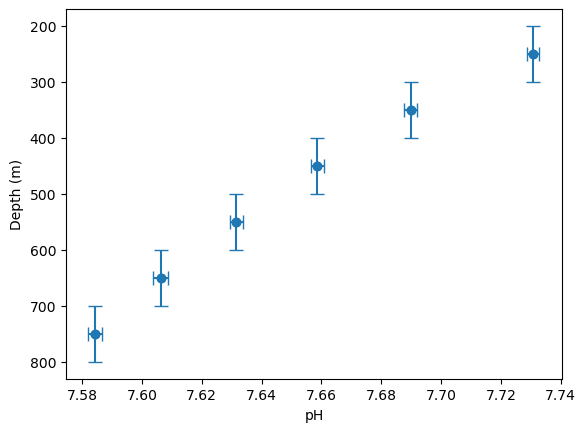

In [5]:
# Plot average pH vs. depth
depths = range(min_depth + int(layer_size/2), max_depth + int(layer_size/2), layer_size)
plt.plot(layer_pH_avgs, depths, 'o')
plt.errorbar(layer_pH_avgs, depths, xerr=layer_pH_sme, yerr=layer_size/2, fmt="o", capsize=5, color="C0")
plt.xlabel('pH')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.show()


## 6. Plot pH Measurement Locations

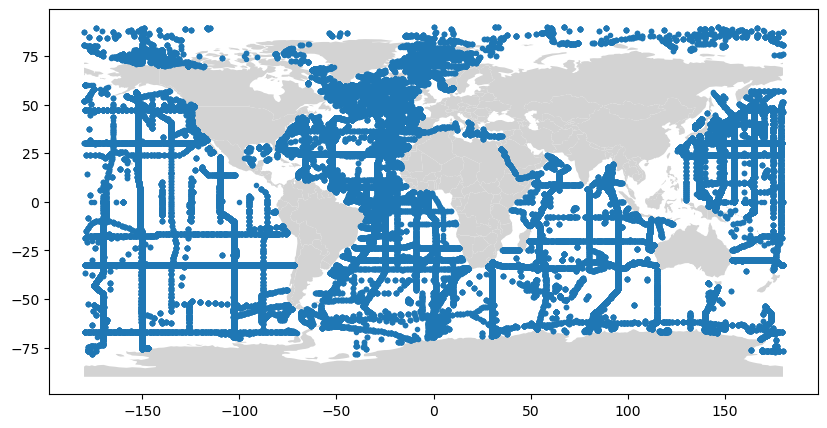

In [6]:
# Plot pH measurement locations
fig, ax = plt.subplots(figsize=(10, 5))
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey", ax=ax)
plt.plot(pH_in_range['G2longitude'], pH_in_range['G2latitude'], '.', color="C0")
plt.show()


## Part 2: REE data
### 1. Load and filter data

In [7]:
m_REE = pd.read_csv('REE_data/REE_seawater_all_pmol.csv')
# Filters from the pH paramters, you can change the paramters into independent variables based on preference.
shallow_depth = m_REE['depth'].between(min_depth, max_depth)
long_range = m_REE['longitude'].between(long_min, long_max)
lat_range = m_REE['latitude'].between(lat_min, lat_max)
location = long_range & lat_range

m_REE = m_REE[shallow_depth & location]
m_REE_copy = m_REE.copy()

### 2. Prepare REE Data for Analysis

In [8]:
from utils import load_coeff
coeffs = load_coeff('coeff/DREE_toyama.csv',
                    'coeff/atomic_number.csv',
                    'coeff/molar_mass_mgmol.csv',
                    'coeff/paas.csv')
_, atomic_num, molar_mass, paas_mol, _= coeffs
# REE conc. in seawater / PAAS [mol/g]/[mol/g] = unitless
REE_list = ['La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd',
            'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu']
m_REE = (m_REE[REE_list]*10**-15).div(paas_mol.loc[0])

# REE slope calc. by lingress slope
selected = ['Sm', 'Gd', 'Dy', 'Er']
labels = ['location']
depth = ['depth']


### 3. Calculate REE Slopes by Linear Regression

In [9]:
# REE slope values by linear regression
all_slopes, lst = [], []
for n in range(0, len(m_REE[selected])):
    slope, intercept, r, p, se = sp.linregress([62, 64, 66, 68],
                                               m_REE[selected].iloc[n])
    x_err_bar = se * 2  # uncertainty is 2 sigma, 98% confidence level
    lst.append([m_REE_copy['location'].iloc[n],
                m_REE_copy['depth'].iloc[n], slope,
                x_err_bar, m_REE_copy['latitude'],
                m_REE_copy['longitude'],
                m_REE['Sm'].iloc[n], m_REE['Gd'].iloc[n],
                m_REE['Dy'].iloc[n], m_REE['Er'].iloc[n]])
    all_slopes.append(slope)

slope_df = pd.DataFrame(lst, columns=['location',
                                      'depth', 'REE_slope', 'slope_error',
                                      'latitude', 'longitude',
                                      'Sm', 'Gd', 'Dy', 'Er'])

### 4. Select location range

In [10]:
location_lst = slope_df['location'].unique().tolist()
loc_i = 0  # start of subset stations
loc_f = len(location_lst)  # end of subset stations

### 5. Average slope for each layer

average REE_slope of  200 - 300 m:  2.564942791181893e-08
average REE_slope of  300 - 400 m:  2.7585760048416105e-08
average REE_slope of  400 - 500 m:  2.833921575620972e-08
average REE_slope of  500 - 600 m:  2.913195075995486e-08
average REE_slope of  600 - 700 m:  3.024820387647606e-08
average REE_slope of  700 - 800 m:  3.2035971215737773e-08


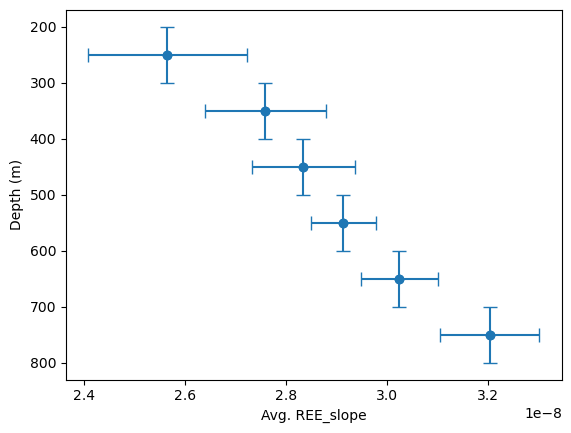

In [11]:
# Finding average REE slope for each layer (parameters in 1st kernel)
layer_slope_avgs = []
layer_slope_error_avgs = []
layer_Sm_avgs = []
layer_Gd_avgs = []
layer_Dy_avgs = []
layer_Er_avgs = []
layer_depth_avgs = []
layer_sme = []
layer_sample_size = []
layer_missing = []
for layer in range(min_depth, max_depth, layer_size):
    layer_range = ((slope_df['depth'] >= layer) &
                   (slope_df['depth'] <= (layer + layer_size)))
    in_loc_lst = (slope_df['location'].isin(location_lst[loc_i:loc_f]))
    layer_df = slope_df[layer_range & in_loc_lst]
    print("average REE_slope of ", layer, "-",
          layer + layer_size, "m: ", layer_df['REE_slope'].mean())
    layer_slope_avgs.append(layer_df['REE_slope'].mean())
    layer_slope_error_avgs.append(layer_df['slope_error'].mean())
    layer_Sm_avgs.append(layer_df['Sm'].mean())
    layer_Gd_avgs.append(layer_df['Gd'].mean())
    layer_Dy_avgs.append(layer_df['Dy'].mean())
    layer_Er_avgs.append(layer_df['Er'].mean())
    layer_depth_avgs.append(str(int(layer)) + 'm - ' +
                            str(int(layer + layer_size)) + 'm')
    if layer_df['REE_slope'].count() != 0:
        layer_sme.append(2*layer_df['REE_slope'].std() /
                         math.sqrt(layer_df['REE_slope'].count()))
    else:
        layer_sme.append(2*layer_df['slope_error'].mean())
    layer_sample_size.append(layer_df['REE_slope'].count())
    layer_missing.append(layer_df['REE_slope'].count() == 0)

plt.plot(layer_slope_avgs,
         range(min_depth+int(layer_size/2), max_depth+int(layer_size/2),
               layer_size), 'o', color="C0")
plt.errorbar(layer_slope_avgs,
             range(min_depth+int(layer_size/2), max_depth+int(layer_size/2),
                   layer_size),
             xerr=layer_sme, yerr=layer_size/2,
             fmt="o", capsize=5, color="C0")
plt.xlabel('Avg. REE_slope')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.show()

### 5. Compute Averages of REE Slope and Concentrations by Layer

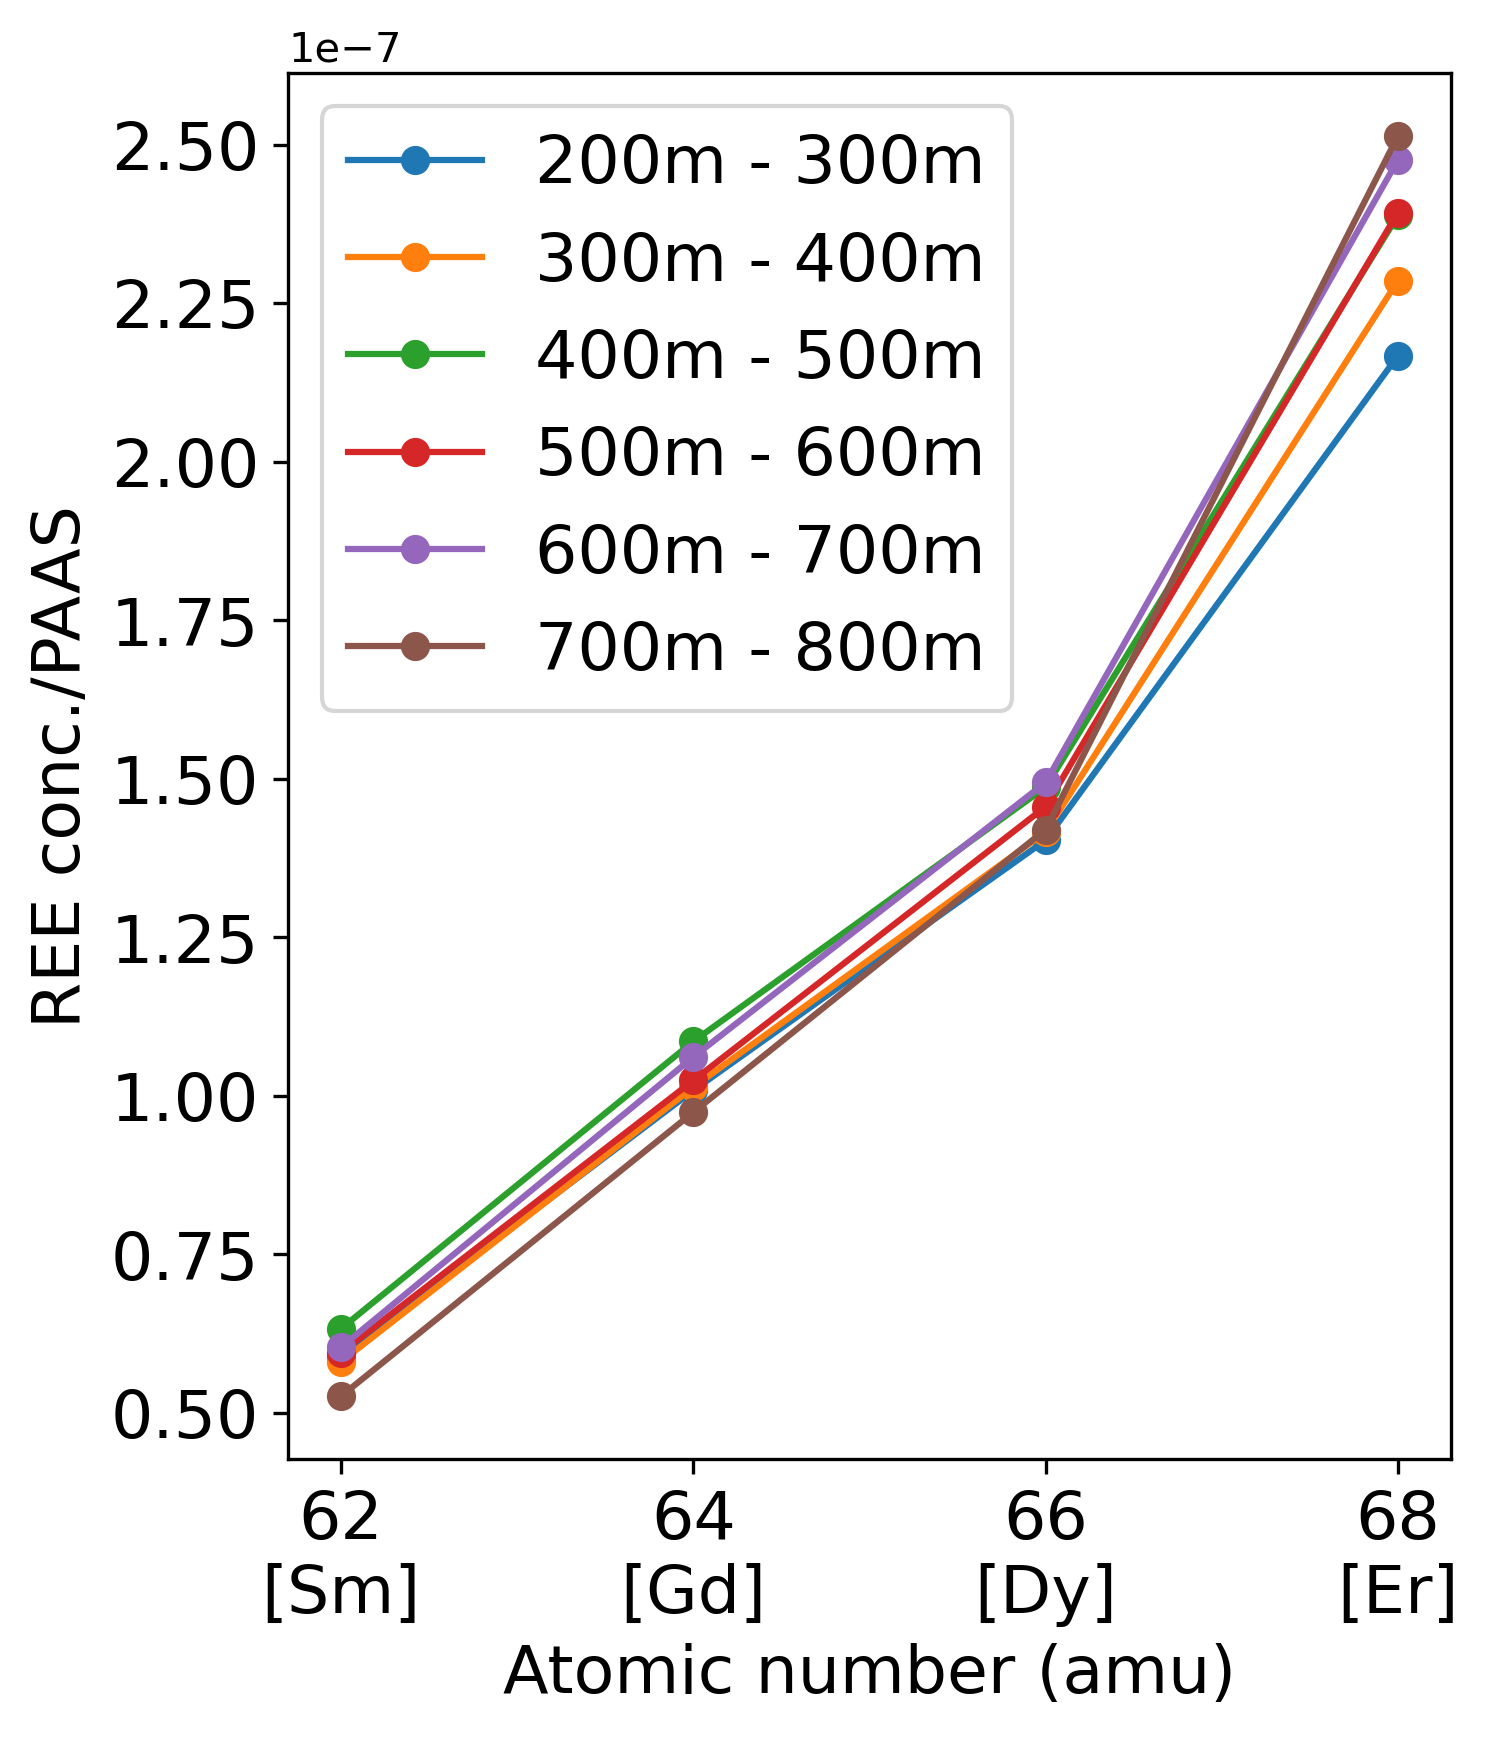

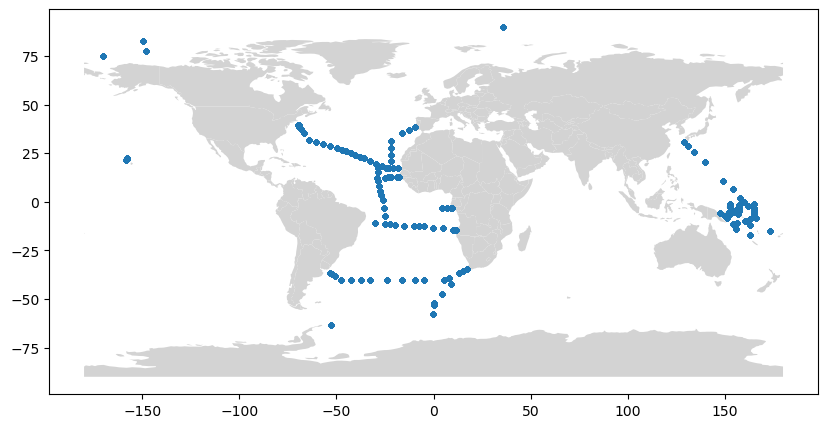

In [12]:
layer_selected_avgs = pd.DataFrame(np.transpose(np.array([layer_Sm_avgs,
                                                          layer_Gd_avgs,
                                                          layer_Dy_avgs,
                                                          layer_Er_avgs])),
                                   columns=['Sm', 'Gd', 'Dy', 'Er'])

plt.figure(figsize=(5, 6), dpi=300)
plt.plot(np.transpose(layer_selected_avgs), 'o-')
plt.legend(layer_depth_avgs, fontsize=16)
plt.ylabel('REE conc./PAAS', size=16)
plt.xlabel('Atomic number (amu)', size=16)
plt.yticks(size=16)
plt.xticks([0, 1, 2, 3], ['62\n[Sm]', '64\n[Gd]', '66\n[Dy]', '68\n[Er]'],
           size=16)
plt.show()

# REE sample locations
fig, ax = plt.subplots(figsize=(10, 5))
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey", ax=ax)
plt.plot(slope_df['longitude'].tolist(),
         slope_df['latitude'].tolist(), '.', color='C0')
plt.show()

## Part 3

### Estimates seawater pH based on the REE slope and visualizes the results.

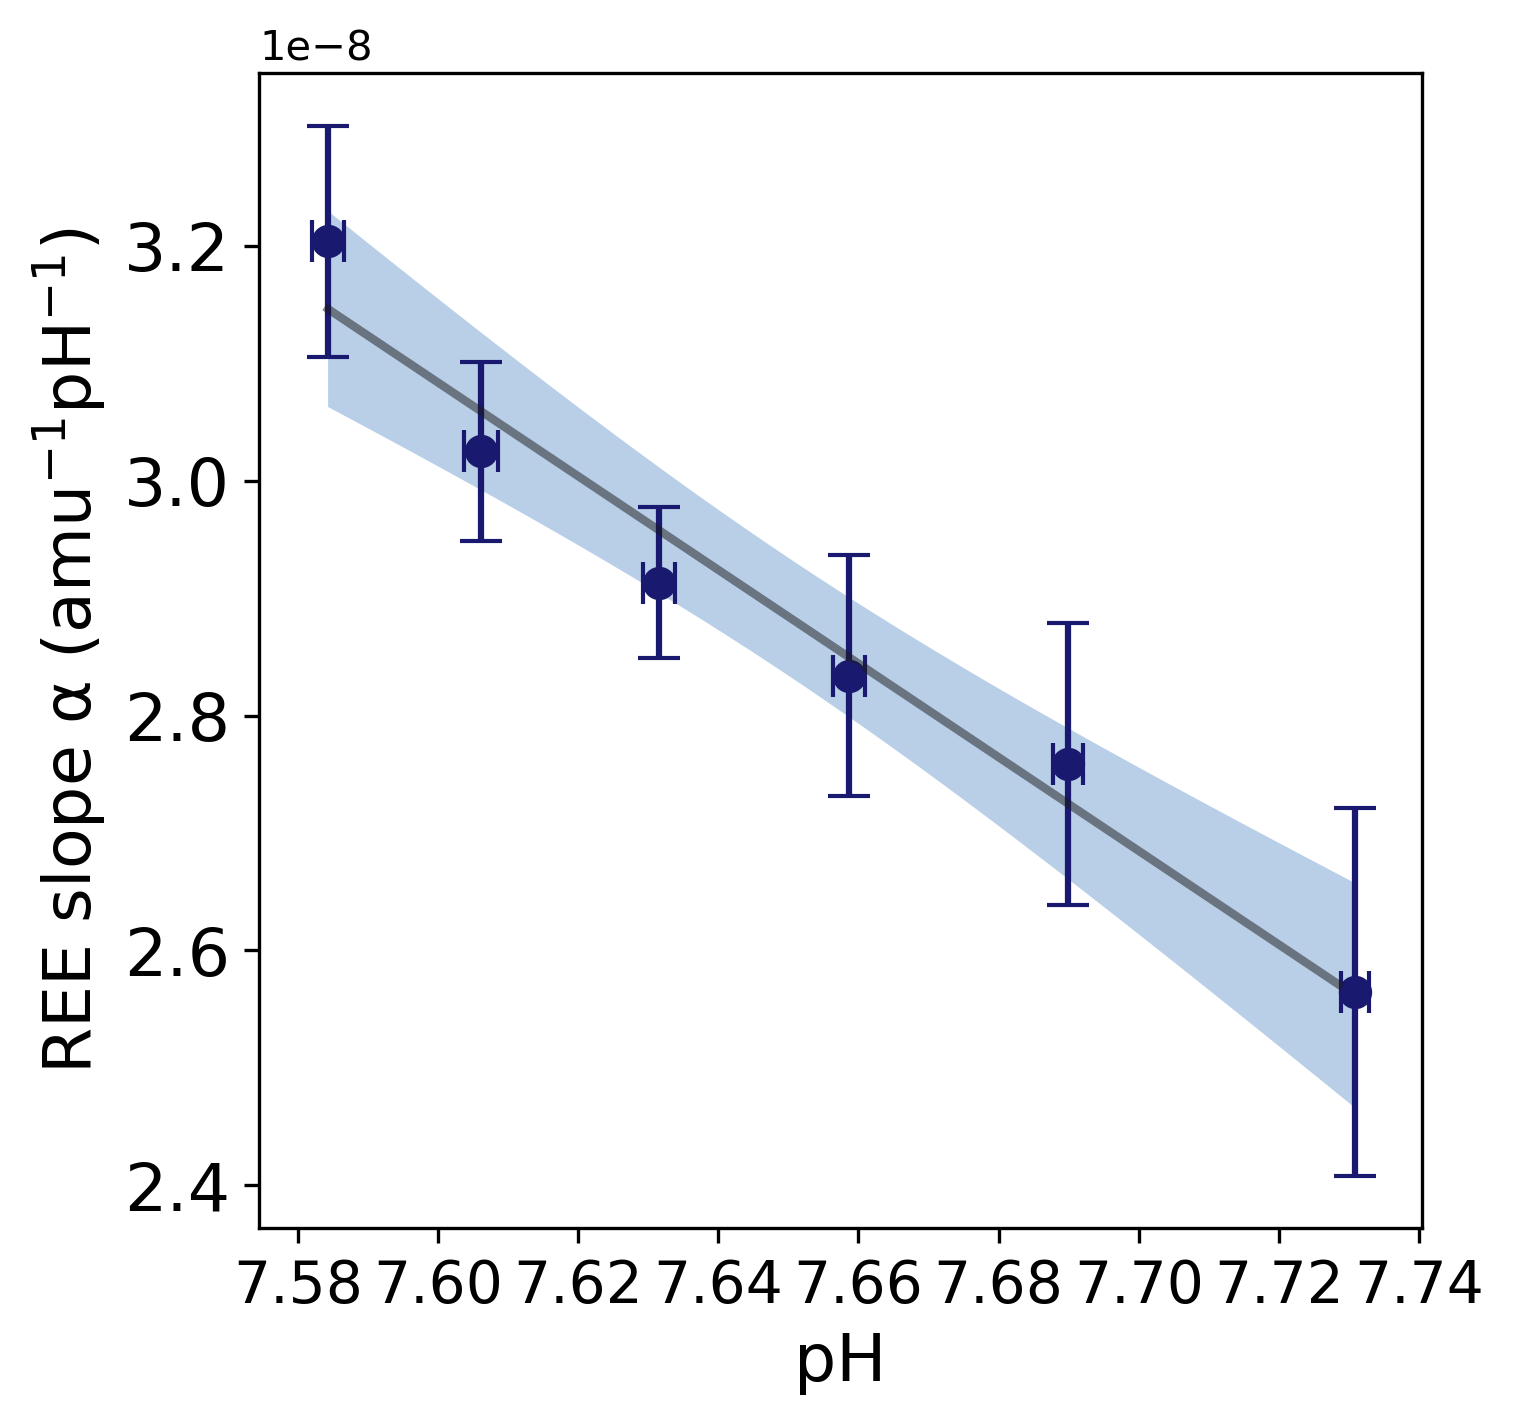

In [13]:
# Get Reg line model pH vs REE slope
# filter out nan
layer_pH_avgs = np.array(layer_pH_avgs)
layer_slope_avgs = np.array(layer_slope_avgs)
layer_sme = np.array(layer_sme)
mask = np.isfinite(layer_pH_avgs) & np.isfinite(layer_slope_avgs)
layer_pH_avgs = layer_pH_avgs[mask]
layer_slope_avgs = layer_slope_avgs[mask]
layer_sme = layer_sme[np.isfinite(layer_sme)]

# Filter out missing data (pH REE mismatch, morelikely REE data missing)
layer_pH_sme_valid = []
for index in range(0, len(layer_missing)):
    if layer_missing[index] == False:
        layer_pH_sme_valid.append(layer_pH_sme[index])


# linear regression prediction
def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):

    if ax is None:
        ax = plt.gca()
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 /
                             np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color="#b9cfe7", edgecolor="none")
    return ax


# Computations ----------------------------------------------------------------
x = layer_pH_avgs
y = layer_slope_avgs


# Modeling with Numpy
def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b)


p, cov = np.polyfit(x, y, 1, cov=True)
y_model = equation(p, x)

# Statistics
n = y.size
m = p.size
dof = n - m
t = sp.t.ppf(0.975, n - m)

# Estimates of Error in Data/Model
resid = y - y_model
chi2 = np.sum((resid / y_model)**2)
chi2_red = chi2 / dof
s_err = np.sqrt(np.sum(resid**2) / dof)

# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

# Data
ax.plot(
    x, y, "o", color="#b9cfe7", markersize=8,
    markeredgewidth=0, markeredgecolor="midnightblue",
    markerfacecolor="midnightblue"
)
# make sure REE length match pH length
plt.errorbar(layer_pH_avgs, layer_slope_avgs,
             xerr=layer_pH_sme_valid, yerr=layer_sme,
             fmt="o", capsize=5, color="midnightblue")

plt.xlabel('pH', size=16)
plt.ylabel('REE slope $\mathregular{α}$ ($\mathregular{amu^{-1}pH^{-1}}$)',
           size=16)
plt.xticks(size=14)
plt.yticks(size=16)

# Fit
ax.plot(x, y_model, "-", color="0.1", linewidth=2, alpha=0.5, label="Fit")

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = equation(p, x2)

# Confidence Interval
plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
plt.show()
